# Hyperion project

- Jacopo Umberto Verga


# Reclustering Macrophages cells:

In [1]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import os
import sys
import pandas as pd
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import time
import gc
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

In [3]:
adata = sc.read('../data/non_denoised/spe_minor_celltypes_final.h5ad')
adata.obs['major_cell_type'] = adata.obs['major_cell_type'].astype('str')
adata.obs['minor_cell_type'] = adata.obs['minor_cell_type'].astype('str')
adata

AnnData object with n_obs × n_vars = 505794 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'Ki-67_minor_cell_type', 'PD-L1_minor_cell_type', 'PD-1_minor_cell_type', 'pSTAT1_minor_cell_type', 'TIM-3_minor_cell_type', 'tissue_id', 'slide_id', 'timepoint', 'patient_n', 'DFCI_id', 'MRN', 'medium_cell_type', 'Ki-67_medium_cell_type', 'PD-L1_medium_cell_type', 'PD-1_medium_cell_type', 'pSTAT1_medium_cell_type', 'TIM-3_medium_cell_type'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

## M1 - PD-L1 and pSTAT1

In [3]:
adata_dc = adata[adata.obs['minor_cell_type'] == 'DC']
adata_dc

View of AnnData object with n_obs × n_vars = 42986 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'patient_n', 'timepoint', 'tissue_id', 'slide_id', 'ROI', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'DFCI_id', 'MRN'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

In [4]:
features_oi=['HLA-DR','CD11c']
df = pd.DataFrame(adata_dc.layers['exprs'], index=adata_dc.obs_names, columns=adata.var_names)
df=df[features_oi]

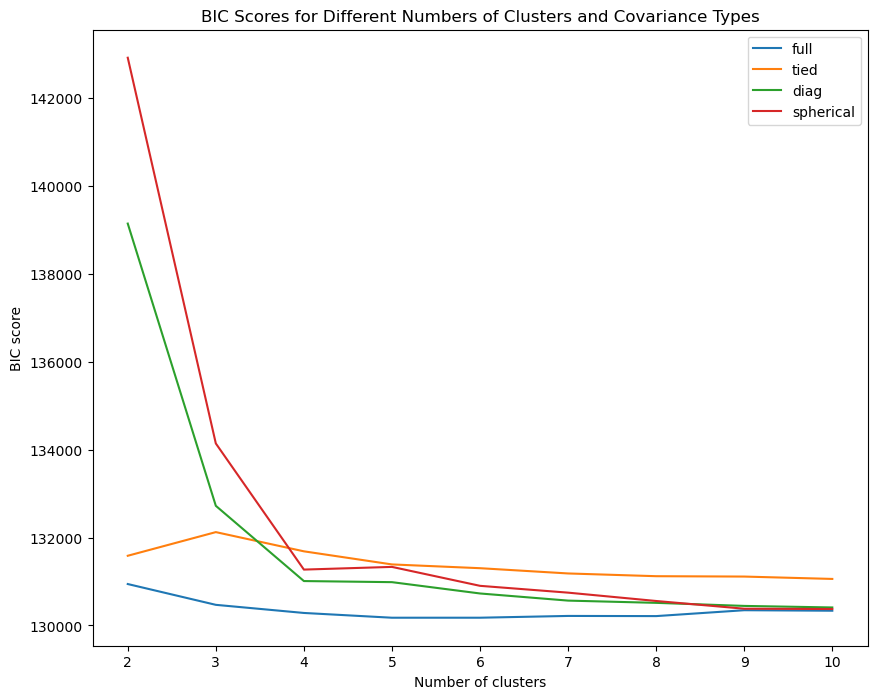

Optimal number of clusters: 5
Optimal covariance type: full


In [5]:

# Example data
np.random.seed(12345)

# Convert to a NumPy array for sklearn
mat = df.values

# Define range of number of clusters and covariance types
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Dictionary to store BIC scores
bic_scores = {}

# Calculate BIC for each combination of number of clusters and covariance type
for covariance_type in covariance_types:
    bic_scores[covariance_type] = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=12345,max_iter=99999)
        gmm.fit(mat)
        bic = gmm.bic(mat)
        bic_scores[covariance_type].append(bic)

# Plot BIC scores for different covariance types
plt.figure(figsize=(10, 8))
for covariance_type in covariance_types:
    plt.plot(n_components_range, bic_scores[covariance_type], label=covariance_type)
plt.xlabel('Number of clusters')
plt.ylabel('BIC score')
plt.title('BIC Scores for Different Numbers of Clusters and Covariance Types')
plt.legend()
plt.show()

# Find the optimal number of clusters and covariance type
best_covariance_type = None
best_n_components = None
min_bic = np.inf

for covariance_type in covariance_types:
    min_bic_covariance = min(bic_scores[covariance_type])
    if min_bic_covariance < min_bic:
        min_bic = min_bic_covariance
        best_covariance_type = covariance_type
        best_n_components = n_components_range[np.argmin(bic_scores[covariance_type])]

print(f'Optimal number of clusters: {best_n_components}')
print(f'Optimal covariance type: {best_covariance_type}')

# Fit the final model using the optimal number of clusters and covariance type
best_gmm = GaussianMixture(n_components=best_n_components, covariance_type=best_covariance_type, random_state=12345,max_iter=99999)
best_gmm.fit(mat)
clusters = best_gmm.predict(mat)


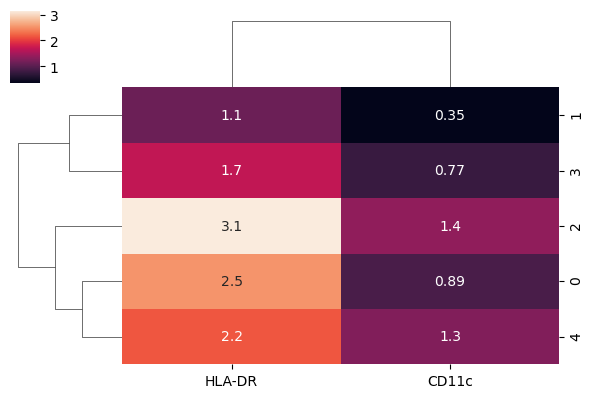

In [6]:
means=pd.DataFrame(best_gmm.means_,columns=features_oi)


sns.clustermap(means, annot=True,figsize=(6, 4))

[None, None, None, None, None]

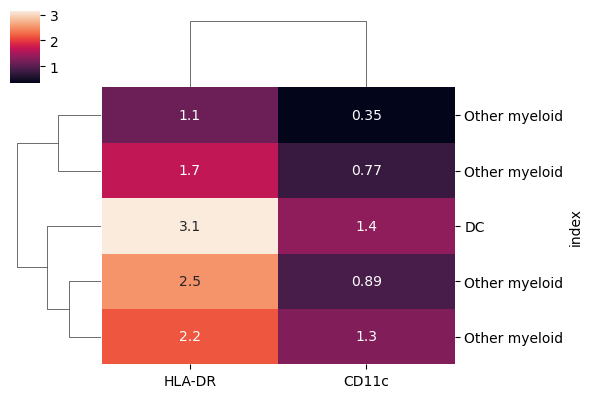

In [7]:
map_clusters={0:'Other myeloid',
              1:'Other myeloid',
              2:'DC',
              3:'Other myeloid',
              4:'Other myeloid'
             }

map_minor_clusters={0:'Other myeloid',
              1:'Other myeloid',
              2:'DC',
              3:'Other myeloid',
              4:'Other myeloid'
             }

means = means.reset_index()
means.index = means['index'].replace(map_minor_clusters)
means = means.drop('index',axis=1)
hm=sns.clustermap(means, annot=True,figsize=(6, 4))
plt.setp(hm.ax_heatmap.get_yticklabels(), rotation=0)


In [8]:
clusters_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_clusters)
clusters_minor_df=pd.DataFrame(clusters,index=df.index)[0].replace(map_minor_clusters)


In [9]:
#adata.obs.loc[clusters_df.index, 'major_cell_type'] = clusters_df
adata.obs.loc[clusters_df.index, 'minor_cell_type'] = clusters_minor_df

<Axes: xlabel='major_cell_type'>

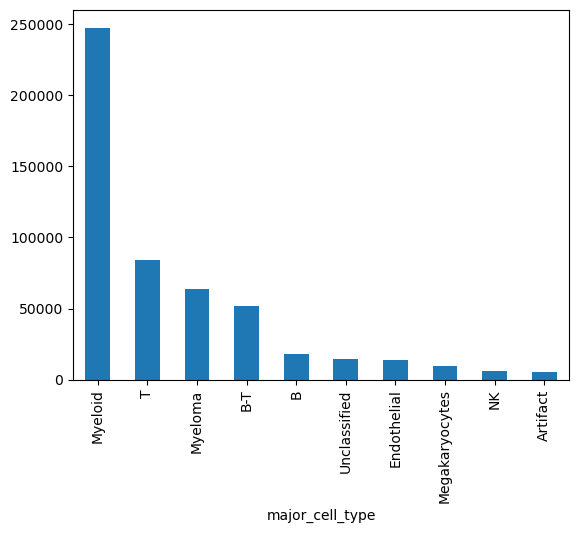

In [10]:
adata.obs['major_cell_type'].value_counts().plot.bar()

<Axes: xlabel='minor_cell_type'>

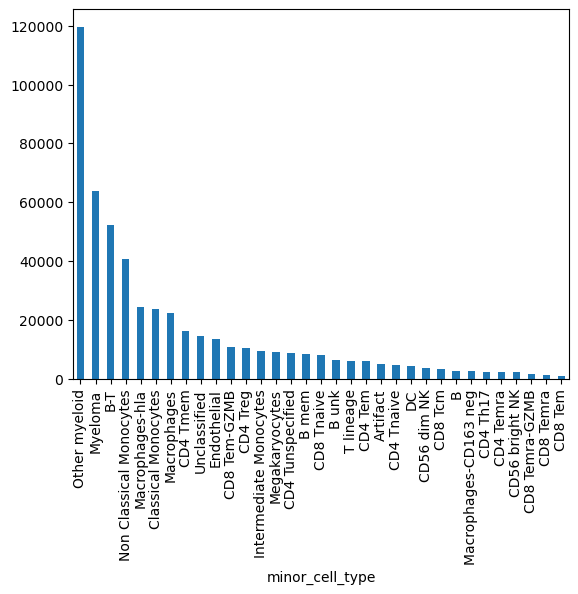

In [11]:
adata.obs['minor_cell_type'].value_counts().plot.bar()

In [12]:
mean_values = (pd.DataFrame(adata.layers['exprs'], index=adata.obs_names,columns=adata.var_names)
               [['aSMA', 'CD14', 'CD16', 'CD163', 'CD11b','CD31', 'CD11c', 
               'CD68', 'HLA-DR', 'CD45RO']]
              )
mean_values = mean_values.groupby(adata.obs['minor_cell_type']).mean()

In [13]:
from matplotlib.colors import to_hex

unique_main_clusters = adata.obs['major_cell_type'].unique()
main_palette = sns.color_palette('hsv', len(unique_main_clusters))

# Create a dictionary mapping main_clusters to colors
main_cluster_colors = {cluster: to_hex(color) for cluster, color in zip(unique_main_clusters, main_palette)}

# Generate shades for sub_clusters within each main_cluster
sub_cluster_colors = {}
for main_cluster in unique_main_clusters:
    sub_clusters = adata.obs[adata.obs['major_cell_type'] == main_cluster]['minor_cell_type'].unique()
    sub_palette = sns.light_palette(main_cluster_colors[main_cluster], len(sub_clusters), reverse=True)
    for sub_cluster, color in zip(sub_clusters, sub_palette):
        sub_cluster_colors[sub_cluster] = to_hex(color)



In [14]:
# Create column_colors DataFrame for the unique sub_clusters
column_colors = pd.DataFrame({
    'main_clusters': mean_values.index.map(lambda x: adata.obs.loc[adata.obs['minor_cell_type'] == x, 'major_cell_type'].values[0]).map(main_cluster_colors),
    'sub_clusters': mean_values.index.map(sub_cluster_colors)
}, index=mean_values.index)

# Transpose the mean_values DataFrame
transposed_mean_values = mean_values.T

# Order the columns by main clusters
ordered_columns = transposed_mean_values.columns[np.argsort([adata.obs.loc[adata.obs['minor_cell_type'] == col, 'major_cell_type'].values[0] for col in transposed_mean_values.columns])]

# Reorder transposed_mean_values and column_colors
transposed_mean_values = transposed_mean_values[ordered_columns]
column_colors = column_colors.loc[ordered_columns]


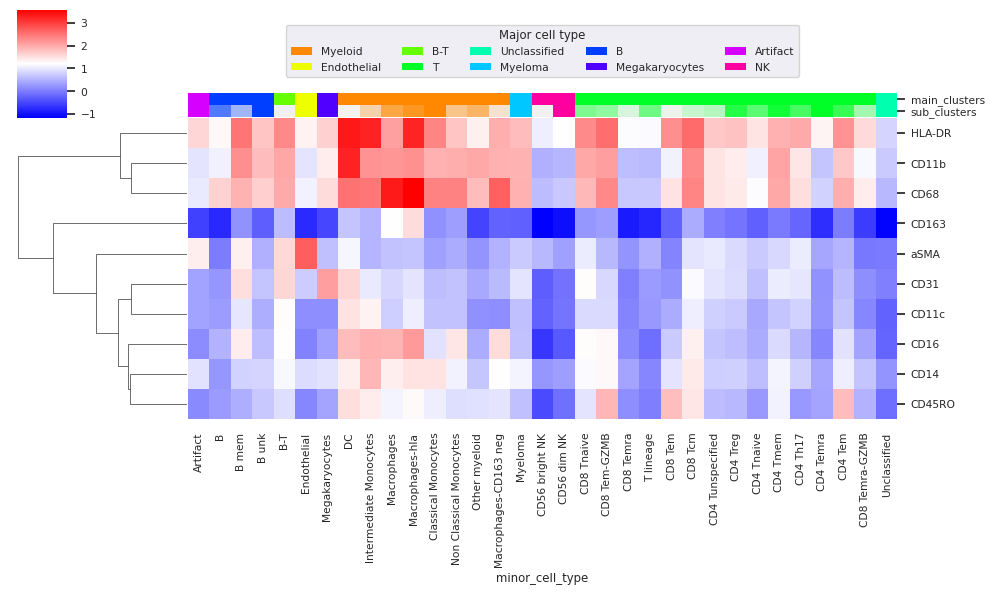

In [15]:
# Create the clustermap
sns.set(font_scale=.7)
g = sns.clustermap(transposed_mean_values,
                   col_colors=column_colors[['main_clusters', 'sub_clusters']],
                   cmap='bwr',
                   figsize=(10, 6),
                   col_cluster=False,  # Disable column clustering since we are manually ordering columns
                   row_cluster=True)  # Enable row clustering if you want to cluster the rows

# Adjust the legend for main and sub cluster colors
for label in unique_main_clusters:
    g.ax_col_dendrogram.bar(0, 0, color=main_cluster_colors[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(title='Major cell type', loc='center', ncol=5)

for label in sub_cluster_colors.keys():
    g.ax_col_dendrogram.bar(0, 0, color=sub_cluster_colors[label],
                            label=label, linewidth=0)

# Adjust the legend for main and sub cluster colors
# Create custom legends
main_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                for label, color in main_cluster_colors.items()]



plt.show()


In [16]:
filename = '../data/non_denoised/spe_minor_celltypes_clean_'+ time.strftime("%Y%m%d-%H%M%S") + '.h5ad'

In [17]:
print(filename)

../data/non_denoised/spe_minor_celltypes_clean_20240626-142029.h5ad


In [18]:
adata.write(filename)